In [2]:
import wandb

wandb.login()


True

Training baseline (non-hierarchical)...
Baseline Final MSE: 0.0220

Training preconditioner...
Training solver on preconditioned space...
Joint fine-tuning both (hierarchical training)...
Hierarchical Final MSE: 0.0112


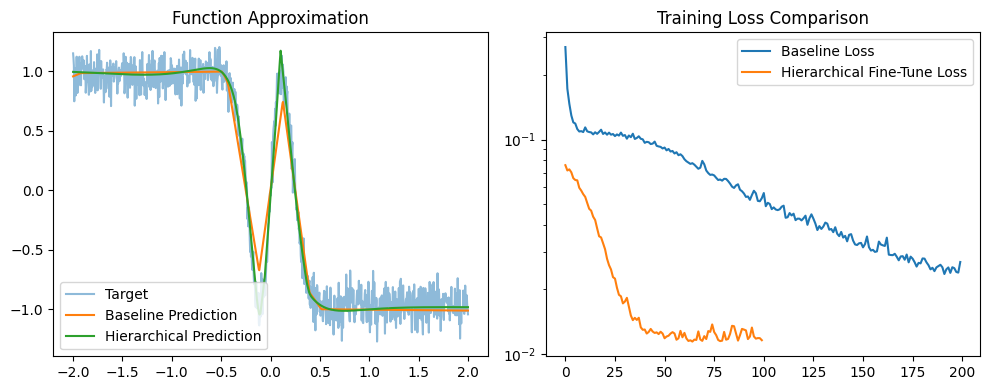

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Set seed for reproducibility
torch.manual_seed(42)

# Generate synthetic data
def generate_data(n=1000):
    x = torch.linspace(-2, 2, n).unsqueeze(1)
    y = torch.sin(5 * torch.tanh(3 * x)) + 0.1 * torch.randn_like(x)
    return x, y

# Preconditioner 
class Preconditioner(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.Tanh(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

# Solver 
class Solver(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# Model 
class FullModel(nn.Module):
    def __init__(self, preconditioner, solver):
        super().__init__()
        self.pre = preconditioner
        self.sol = solver

    def forward(self, x):
        x = self.pre(x)
        return self.sol(x)

# Training function
def train(model, data_loader, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for x_batch, y_batch in data_loader:
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

# Evaluation function
def evaluate(model, x, y):
    model.eval()
    with torch.no_grad():
        y_pred = model(x)
        return ((y_pred - y) ** 2).mean().item(), y_pred

# Prepare data
x, y = generate_data()
dataset = TensorDataset(x, y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
loss_fn = nn.MSELoss()

### --- Non-Hierarchical Model (baseline) ---
baseline_model = Solver()
optimizer_baseline = optim.Adam(baseline_model.parameters(), lr=0.01)

print("Training baseline (non-hierarchical)...")
baseline_losses = []
for epoch in range(200):
    loss = train(baseline_model, loader, loss_fn, optimizer_baseline)
    baseline_losses.append(loss)

mse_base, y_pred_base = evaluate(baseline_model, x, y)
print(f"Baseline Final MSE: {mse_base:.4f}")

### --- Hierarchical Training ---
# 1. Train preconditioner
pre = Preconditioner()
opt_pre = optim.Adam(pre.parameters(), lr=0.01)
print("\nTraining preconditioner...")
for epoch in range(100):
    loss = train(pre, loader, loss_fn, opt_pre)

# 2. Train solver on top (freeze pre)
sol = Solver()
for param in pre.parameters():
    param.requires_grad = False
full_model = FullModel(pre, sol)
opt_sol = optim.Adam(sol.parameters(), lr=0.01)
print("Training solver on preconditioned space...")
for epoch in range(100):
    loss = train(full_model, loader, loss_fn, opt_sol)

# 3. Joint fine-tuning
for param in pre.parameters():
    param.requires_grad = True
opt_joint = optim.Adam(full_model.parameters(), lr=0.005)
hierarchical_losses = []
print("Joint fine-tuning both (hierarchical training)...")
for epoch in range(100):
    loss = train(full_model, loader, loss_fn, opt_joint)
    hierarchical_losses.append(loss)

mse_hier, y_pred_hier = evaluate(full_model, x, y)
print(f"Hierarchical Final MSE: {mse_hier:.4f}")

### Plot Comparison 
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(x, y, label="Target", alpha=0.5)
plt.plot(x, y_pred_base, label="Baseline Prediction")
plt.plot(x, y_pred_hier, label="Hierarchical Prediction")
plt.title("Function Approximation")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(baseline_losses, label="Baseline Loss")
plt.plot(hierarchical_losses, label="Hierarchical Fine-Tune Loss")
plt.title("Training Loss Comparison")
plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
from synthetic_data_generator import create_synthetic_matrix, create_synthetic_data
from GNP import GNP, scale_A_by_spectral_radius
from ResGCN import ResGCN
from GMRES import GMRES
from scipy.sparse import csc_matrix, identity
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math

ModuleNotFoundError: No module named 'synthetic_data_generator'

In [ ]:
Lx = 1000 # Size of domain in km
dxm = 2 # Mesh resolution in km
n2d = np.arange(0, Lx + 1, dxm, dtype="float32").shape[0]**2 # Number of mesh nodes

ss, ii, jj, tri, xcoord, ycoord = create_synthetic_matrix(Lx, dxm, False)
tt = create_synthetic_data(Lx, dxm)

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
triang = mpl.tri.Triangulation(xcoord, ycoord, tri)

plt.tripcolor(triang, tt)
plt.colorbar()

In [ ]:
num_layers = 8              # number of layers in GNP
embed = 32                  # embedding dimension in GNP
hidden = 64                 # hidden dimension in MLPs in GNP
drop_rate = 0.05            # dropout rate in GNP
disable_scale_input = False # whether disable the scaling of inputs in GNP
dtype = torch.float64       # training precision for GNP
lr = 2e-3                   # learning rate in training GNP
weight_decay = 0.0          # weight decay in training GNP
training_data = 'x_mix'     # type of training data x
m = 80                      # Krylov subspace dimension for training data
batch_size = 4              # batch size in training GNP
grad_accu_steps = 1         # gradient accumulation steps in training GNP
epochs = 1000               # number of epochs in training GNP 

In [ ]:
kc = 2 * math.pi / np.logspace(1, 3, 10) # 10 values from 10 to 1000 km


In [ ]:
tt.shape


In [ ]:
n = 1 # Filter order
device = torch.device("cuda")
solver = GMRES()
As = []

for k in kc: # Looping over the scales
    Smat1 = csc_matrix((ss * (1.0 / np.square(k)), (ii, jj)), shape=(n2d, n2d))
    Smat = identity(n2d) + 2.0 * (Smat1 ** n)
    A = torch.sparse_csc_tensor(Smat.indptr, Smat.indices, Smat.data, Smat.shape, dtype=torch.float64).to(device)
    A = scale_A_by_spectral_radius(A)
    As += [A]
    
data = torch.tensor(np.array(tt), device=device, dtype=torch.float64)

In [ ]:
net = ResGCN(As[-1], num_layers, embed, hidden, drop_rate, scale_input=True, dtype=dtype).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None
M = GNP(A, training_data, m, net, device)

In [ ]:
iterations = np.zeros(len(As))

for i in range(len(As)):
    ttw = data - As[i] @ data  # Work with perturbations
    x, iters, _, _, _ = solver.solve(A=As[i], b=ttw, rtol=1e-6, max_iters=20000, progress_bar=False)
    print("Iteration " + str(iters))
    iterations[i] = iters

In [ ]:
plt.plot(np.logspace(1, 3, 10), iterations)
plt.xlabel("Length [km]")
plt.ylabel("Iterations")
plt.xscale("log")
plt.yscale("log")

In [ ]:
import time 

tic = time.time()
hist_loss, best_loss, best_epoch, model_file = M.train(
    batch_size, grad_accu_steps, epochs, optimizer, scheduler, num_workers=4,
    checkpoint_prefix_with_path="./tmp_", progress_bar=False)
M.net.load_state_dict(torch.load(f"./tmp_epoch_{best_epoch}.pt", map_location=device, weights_only=True))

print(f'Done. Training time: {time.time()-tic} seconds')
print(f'Loss: inital = {hist_loss[0]}, final = {hist_loss[-1]}, best = {best_loss}, epoch = {best_epoch}')

In [ ]:
iterations_pre = np.zeros(len(As))

for i in range(len(As)):
    ttw = data - As[i] @ data  # Work with perturbations
    x, iters, _, _, _ = solver.solve(A=As[i], b=ttw, rtol=1e-6, max_iters=20000, progress_bar=False, M=M)
    print("Iteration " + str(iters))
    iterations_pre[i] = iters

In [ ]:
plt.plot(np.logspace(1, 3, 10), iterations, label="No preconditioner")
plt.plot(np.logspace(1, 3, 10), iterations_pre, label="One phase of training")

plt.xlabel("Length [km]")
plt.ylabel("Iterations")
plt.xscale("log")
plt.yscale("log")
plt.legend()
    

In [ ]:
! rm ./*.pt


In [ ]:
net = ResGCN(As[0], num_layers, embed, hidden, drop_rate, scale_input=True, dtype=dtype).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None
M = GNP(A, training_data, m, net, device)

for A in As: 
    M.A = A
    hist_loss, best_loss, best_epoch, model_file = M.train(
    batch_size, grad_accu_steps, epochs // 10, optimizer, scheduler, num_workers=4, 
    checkpoint_prefix_with_path="./tmp_", progress_bar=False)
    M.net.load_state_dict(torch.load(f"./tmp_epoch_{best_epoch}.pt", map_location=device, weights_only=True))
    print(f'Loss: inital = {hist_loss[0]}, final = {hist_loss[-1]}, best = {best_loss}, epoch = {best_epoch}')
    

In [ ]:
iterations_post = np.zeros(len(As))

for i in range(len(As)):
    ttw = data - As[i] @ data  # Work with perturbations
    x, iters, _, _, _ = solver.solve(A=As[i], b=ttw, rtol=1e-6, max_iters=20000, progress_bar=False, M=M)
    print("Iteration " + str(iters))
    iterations_post[i] = iters

In [ ]:
plt.plot(np.logspace(1, 3, 10), iterations, label="No preconditioner")
plt.plot(np.logspace(1, 3, 10), iterations_pre, label="One phase of training")
plt.plot(np.logspace(1, 3, 10), iterations_post, label="10 phases of training")

plt.xlabel("Length [km]")
plt.ylabel("Iterations")
plt.xscale("log")
plt.yscale("log")
plt.legend()